In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
from helper_functions import calibration_curves
sns.set_theme(
    context="talk",
    style="ticks",
    rc={"font.sans-serif": ["Arial", "Fira Sans Condensed"]},
)

In [29]:
# train_set = "mnist"
train_set = "mura"

# eval_datasets = ["mnist", "svhn"]
eval_datasets = ["mura"]

results_folder = f"../results/{train_set}"
figure_folder = "../reports/figures"
table_folder = "../reports/tables"

type_dict = {
    "radial": {"color": "#4E79A7", "style": "solid"},
    "radial_200": {"color": "#4E79A7", "style": "dotted"},
    "radial_200_lowlr": {"color": "#4E79A7", "style": "dashed"},
    "meanfield": {"color": "#F28E2B", "style": "dotted"},
    "laplace": {"color": "#59A14F", "style": "dashed"},
    "lowrank": {"color": "#B6992D", "style": "dashdot"},
    "ml": {"color": "#499894", "style": "solid"},
    "map": {"color": "#E15759", "style": "solid"},
    "ensemble_5": {"color": "#BAB0AC", "style": "solid"},
    "ensemble_10": {"color": "#79706E", "style": "solid"},
    "multiswag_5": {"color": "#D37295", "style": "solid"},
    "multiswag_10": {"color": "#FABFD2", "style": "solid"},
}

types = [
    "ensemble_5",
    "ensemble_10",
    "multiswag_5",
    "multiswag_10",
    "radial",
    # "radial_200",
    # "radial_200_lowlr",
    "meanfield",
    "lowrank",
    "laplace",
    "ml",
    "map",
]

results = pd.DataFrame()
for dataset in eval_datasets:

    df = []
    for type in types:
        with open(f"{results_folder}/{type}.pkl", "rb") as f:
            data = pickle.load(f)[f"eval_{dataset}"]
            df.append(data)
    df = pd.DataFrame.from_dict(df)
    df.insert(0, "Type", types)
    results = pd.concat([results, df])

results = results.rename(columns={
    "Average confidence": "Avg. Conf.",
    "Average confidence when wrong": "Avg. Conf. -",
    "Average confidence when right": "Avg. Conf. +",
})

bins = 10
for i, dataset in enumerate(eval_datasets):
    for type in types:
        criteria = f"`Evaluated on` == '{dataset}' and Type == '{type}'"
        data = results.query(criteria)

        targets = data["Test targets"].values[0][:,None]
        probs = data["Test probabilities"].values[0]
        confidences = np.max(probs, axis=1)

        ece, prob_true, prob_pred, n_in_bins = calibration_curves(targets, probs, bins=bins)
        error = 2*np.sqrt( (prob_true * (1-prob_true)) / n_in_bins[n_in_bins > 0] )
        results.loc[results.eval(criteria), 'ECE'] = ece

# Ensembles

,Type,Evaluated on,NLL,Accuracy,AUROC,Avg. Conf.,Avg. Conf. -,Avg. Conf. +,ECE
0,ensemble_5,mura,-0.561425,0.709415,0.938018,0.650341,0.491456,0.715423,0.059197
1,ensemble_10,mura,-0.558677,0.715984,0.939427,0.643597,0.485155,0.706447,0.072387


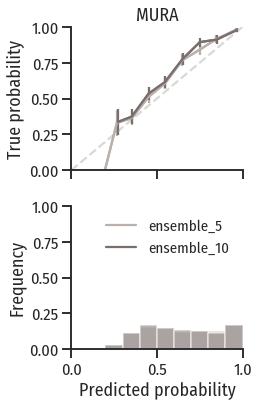

In [30]:
bins = 10

types = [
    "ensemble_5",
    "ensemble_10",
]

fig, ax = plt.subplots(ncols=len(eval_datasets), nrows=2, sharex="all", sharey="all", figsize=(4*len(eval_datasets), 6))
# fig, ax = plt.subplots(ncols=len(eval_datasets), nrows=2, sharex="all", sharey="all", figsize=(5*len(eval_datasets), 8))
for i, dataset in enumerate(eval_datasets):
    ax_curve = ax[0, i] if len(eval_datasets) > 1 else ax[0]
    ax_hist = ax[1, i] if len(eval_datasets) > 1 else ax[1]
    for type in types:
        criteria = f"`Evaluated on` == '{dataset}' and Type == '{type}'"
        data = results.query(criteria)

        targets = data["Test targets"].values[0][:,None]
        probs = data["Test probabilities"].values[0]
        confidences = np.max(probs, axis=1)

        ece, prob_true, prob_pred, n_in_bins = calibration_curves(targets, probs, bins=bins)
        error = 2*np.sqrt( (prob_true * (1-prob_true)) / n_in_bins[n_in_bins > 0] )
        results.loc[results.eval(criteria), 'ECE'] = ece

        line, = ax_curve.plot(prob_pred, prob_true, label=f"{type}", c=type_dict[type]["color"], linestyle=type_dict[type]["style"])
        ax_curve.errorbar(x=prob_pred, y=prob_true, yerr=error, c=line.get_color(), linestyle=type_dict[type]["style"])

        ax_hist.bar(np.linspace(0, 1, bins+1)[-bins:]-1/(2*bins), n_in_bins / np.sum(n_in_bins), width=1/bins, color=line.get_color(), alpha=0.5, label=f"{type}")

    ls = np.linspace(0, 1)
    ax_curve.plot(ls, ls, "--", color="grey", alpha=0.3)
    ax_curve.set(
        xlim=(0, 1),
        ylim=(0, 1),
        title=dataset.upper(),
    )
    ax_hist.set(
        xlim=(0, 1),
        ylim=(0, 1),
    )
    if i == 0:
        ax_curve.set(
            ylabel="True probability",
        )
        ax_hist.set(
            xlabel="Predicted probability",
            ylabel="Frequency",
        )
    if i == len(eval_datasets)-1:
        ax_hist.legend(*ax_curve.get_legend_handles_labels(), frameon=False, fontsize="small")
        ax_hist.set(
            xlabel="Predicted probability",
        )

fig.tight_layout()
sns.despine(fig)

fig.savefig(f"{figure_folder}/{train_set.capitalize()}Ensembles.pdf")

results.query("`Evaluated on` in @eval_datasets and `Type` in @types").drop(["Test targets", "Test probabilities"], axis=1)

# Guides

,Type,Evaluated on,NLL,Accuracy,AUROC,Avg. Conf.,Avg. Conf. -,Avg. Conf. +,ECE
4,radial,mura,1.453502,0.437598,0.795566,0.475476,0.405818,0.565001,0.061835
5,meanfield,mura,1.766220,0.351892,0.684228,0.393481,0.345995,0.480940,0.047952
6,lowrank,mura,1.606285,0.371598,0.749881,0.358181,0.298902,0.458426,0.023085
7,laplace,mura,1.675914,0.383485,0.700265,0.403400,0.348647,0.491424,0.048065


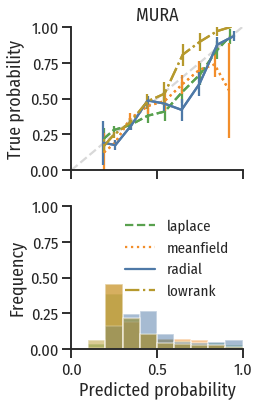

In [5]:
bins = 10

types = [
    # "ml",
    # "map",
    "laplace",
    "meanfield",
    "radial",
    # "radial_200",
    # "radial_200_lowlr",
    "lowrank",
]


fig, ax = plt.subplots(ncols=len(eval_datasets), nrows=2, sharex="all", sharey="all", figsize=(4*len(eval_datasets),6))
for i, dataset in enumerate(eval_datasets):
    ax_curve = ax[0, i] if len(eval_datasets) > 1 else ax[0]
    ax_hist = ax[1, i] if len(eval_datasets) > 1 else ax[1]
    for type in types:
        criteria = f"`Evaluated on` == '{dataset}' and Type == '{type}'"
        data = results.query(criteria)

        targets = data["Test targets"].values[0][:,None]
        probs = data["Test probabilities"].values[0]
        confidences = np.max(probs, axis=1)

        ece, prob_true, prob_pred, n_in_bins = calibration_curves(targets, probs, bins=bins)
        error = 2*np.sqrt( (prob_true * (1-prob_true)) / n_in_bins[n_in_bins > 0] )
        results.loc[results.eval(criteria), 'ECE'] = ece

        line, = ax_curve.plot(prob_pred, prob_true, label=f"{type}", c=type_dict[type]["color"], linestyle=type_dict[type]["style"])
        ax_curve.errorbar(x=prob_pred, y=prob_true, yerr=error, c=line.get_color(), linestyle=type_dict[type]["style"])

        ax_hist.bar(np.linspace(0, 1, bins+1)[-bins:]-1/(2*bins), n_in_bins / np.sum(n_in_bins), width=1/bins, color=line.get_color(), alpha=0.5, label=f"{type}")

    ls = np.linspace(0, 1)
    ax_curve.plot(ls, ls, "--", color="grey", alpha=0.3)
    ax_curve.set(
        xlim=(0, 1),
        ylim=(0, 1),
        title=dataset.upper(),
    )
    ax_hist.set(
        xlim=(0, 1),
        ylim=(0, 1),
    )
    if i == 0:
        ax_curve.set(
            ylabel="True probability",
        )
        ax_hist.set(
            xlabel="Predicted probability",
            ylabel="Frequency",
        )
    if i == len(eval_datasets)-1:
        ax_hist.legend(*ax_curve.get_legend_handles_labels(), frameon=False, fontsize="small")
        ax_hist.set(
            xlabel="Predicted probability",
        )

fig.tight_layout()
sns.despine(fig)

fig.savefig(f"{figure_folder}/{train_set.capitalize()}VI.pdf")

results.query("`Evaluated on` in @eval_datasets and `Type` in @types").drop(["Test targets", "Test probabilities"], axis=1)

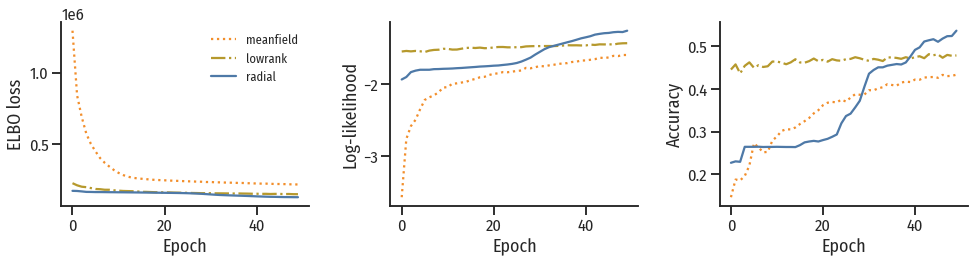

In [6]:
fig, ax = plt.subplots(ncols=3, figsize=(14,4))
for guide in [
    "meanfield",
    "lowrank",
    "radial",
    # "radial_200",
    # "radial_200_lowlr",
]:
    with open(f"{results_folder}/{guide}.pkl", "rb") as f:
        data = pickle.load(f)
        epochs = np.arange(len(data["Training ELBO"]))
        ax[0].plot(epochs, data["Training ELBO"].squeeze(), label=guide, c=type_dict[guide]["color"], linestyle=type_dict[guide]["style"])
        ax[1].plot(epochs, data["Validation log-likelihood"].squeeze(), label=guide, c=type_dict[guide]["color"], linestyle=type_dict[guide]["style"])
        ax[2].plot(epochs, data["Validation accuracy"].squeeze(), label=guide, c=type_dict[guide]["color"], linestyle=type_dict[guide]["style"])
ax[0].set(
    xlabel="Epoch",
    ylabel="ELBO loss",
)
ax[1].set(
    xlabel="Epoch",
    ylabel="Log-likelihood",
)
ax[2].set(
    xlabel="Epoch",
    ylabel="Accuracy",
)
ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax[0].legend(frameon=False, fontsize="x-small")

fig.tight_layout()
sns.despine(fig)

# MultiSWAG

,Type,Evaluated on,NLL,Accuracy,AUROC,Avg. Conf.,Avg. Conf. -,Avg. Conf. +,ECE
2,multiswag_5,mura,-0.591607,0.718799,0.940862,0.684732,0.514897,0.751174,0.034190
3,multiswag_10,mura,-0.589532,0.720676,0.942285,0.678781,0.507247,0.745265,0.042017


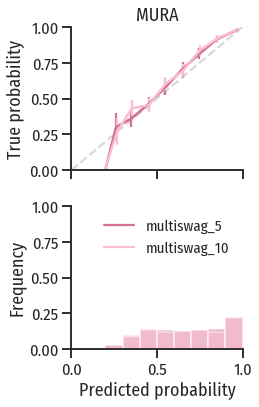

In [7]:
bins = 10

types = [
    "multiswag_5",
    "multiswag_10",
]

fig, ax = plt.subplots(ncols=len(eval_datasets), nrows=2, sharex="all", sharey="all", figsize=(4*len(eval_datasets),6))
for i, dataset in enumerate(eval_datasets):
    ax_curve = ax[0, i] if len(eval_datasets) > 1 else ax[0]
    ax_hist = ax[1, i] if len(eval_datasets) > 1 else ax[1]
    for type in types:
        criteria = f"`Evaluated on` == '{dataset}' and Type == '{type}'"
        data = results.query(criteria)

        targets = data["Test targets"].values[0][:,None]
        probs = data["Test probabilities"].values[0]
        confidences = np.max(probs, axis=1)

        ece, prob_true, prob_pred, n_in_bins = calibration_curves(targets, probs, bins=bins)
        error = 2*np.sqrt( (prob_true * (1-prob_true)) / n_in_bins[n_in_bins > 0] )
        results.loc[results.eval(criteria), 'ECE'] = ece

        line, = ax_curve.plot(prob_pred, prob_true, label=f"{type}", c=type_dict[type]["color"], linestyle=type_dict[type]["style"])
        ax_curve.errorbar(x=prob_pred, y=prob_true, yerr=error, c=line.get_color(), linestyle=type_dict[type]["style"])

        ax_hist.bar(np.linspace(0, 1, bins+1)[-bins:]-1/(2*bins), n_in_bins / np.sum(n_in_bins), width=1/bins, color=line.get_color(), alpha=0.5, label=f"{type}")

    ls = np.linspace(0, 1)
    ax_curve.plot(ls, ls, "--", color="grey", alpha=0.3)
    ax_curve.set(
        xlim=(0, 1),
        ylim=(0, 1),
        title=dataset.upper(),
    )
    ax_hist.set(
        xlim=(0, 1),
        ylim=(0, 1),
    )
    if i == 0:
        ax_curve.set(
            ylabel="True probability",
        )
        ax_hist.set(
            xlabel="Predicted probability",
            ylabel="Frequency",
        )
    if i == len(eval_datasets)-1:
        ax_hist.legend(*ax_curve.get_legend_handles_labels(), frameon=False, fontsize="small")
        ax_hist.set(
            xlabel="Predicted probability",
        )

fig.tight_layout()
sns.despine(fig)

fig.savefig(f"{figure_folder}/{train_set.capitalize()}MultiSwag.pdf")

results.query("`Evaluated on` in @eval_datasets and `Type` in @types").drop(["Test targets", "Test probabilities"], axis=1)

In [8]:
results.drop(["Test targets", "Test probabilities"], axis=1)

,Type,Evaluated on,NLL,Accuracy,AUROC,Avg. Conf.,Avg. Conf. -,Avg. Conf. +,ECE
0,ensemble_5,mura,-0.561425,0.709415,0.938018,0.650341,0.491456,0.715423,0.059197
1,ensemble_10,mura,-0.558677,0.715984,0.939427,0.643597,0.485155,0.706447,0.072387
2,multiswag_5,mura,-0.591607,0.718799,0.940862,0.684732,0.514897,0.751174,0.034190
3,multiswag_10,mura,-0.589532,0.720676,0.942285,0.678781,0.507247,0.745265,0.042017
4,radial,mura,1.453502,0.437598,0.795566,0.475476,0.405818,0.565001,0.061835
5,meanfield,mura,1.766220,0.351892,0.684228,0.393481,0.345995,0.480940,0.047952
6,lowrank,mura,1.606285,0.371598,0.749881,0.358181,0.298902,0.458426,0.023085
7,laplace,mura,1.675914,0.383485,0.700265,0.403400,0.348647,0.491424,0.048065
8,ml,mura,1.231510,0.550829,0.861678,0.520280,0.437506,0.587777,0.034931
9,map,mura,1.710259,0.358461,0.673244,0.415495,0.351600,0.529847,0.060089


In [27]:
from pandas.io.formats.style import Styler

s: Styler = results\
    .drop(["Test targets", "Test probabilities"], axis=1)\
    .replace({
        "mnist": "MNIST",
        "svhn": "SVHN",
        "mura": "MURA",
        "ensemble_5": "Ensemble@5",
        "ensemble_10": "Ensemble@10",
        "multiswag_5": "MultiSWAG@5",
        "multiswag_10": "MultiSWAG@10",
        "radial": "Radial",
        "meanfield": "Mean-field",
        "lowrank": "Low-rank",
        "laplace": "Laplace",
        "ml": "ML",
        "map": "MAP",
    })\
    .style
s.format(precision=3)
s.hide(axis="index")
latex_table = s.to_latex()
print(latex_table)
with open(f"{table_folder}/{train_set}_full.tex", "w") as f:
    f.write(latex_table)

\begin{tabular}{llrrrrrrr}
Type & Evaluated on & NLL & Accuracy & AUROC & Avg. Conf. & Avg. Conf. - & Avg. Conf. + & ECE \\
Ensemble@5 & MURA & -0.561 & 0.709 & 0.938 & 0.650 & 0.491 & 0.715 & 0.059 \\
Ensemble@10 & MURA & -0.559 & 0.716 & 0.939 & 0.644 & 0.485 & 0.706 & 0.072 \\
MultiSWAG@5 & MURA & -0.592 & 0.719 & 0.941 & 0.685 & 0.515 & 0.751 & 0.034 \\
MultiSWAG@10 & MURA & -0.590 & 0.721 & 0.942 & 0.679 & 0.507 & 0.745 & 0.042 \\
Radial & MURA & 1.454 & 0.438 & 0.796 & 0.475 & 0.406 & 0.565 & 0.062 \\
Mean-field & MURA & 1.766 & 0.352 & 0.684 & 0.393 & 0.346 & 0.481 & 0.048 \\
Low-rank & MURA & 1.606 & 0.372 & 0.750 & 0.358 & 0.299 & 0.458 & 0.023 \\
Laplace & MURA & 1.676 & 0.383 & 0.700 & 0.403 & 0.349 & 0.491 & 0.048 \\
ML & MURA & 1.232 & 0.551 & 0.862 & 0.520 & 0.438 & 0.588 & 0.035 \\
MAP & MURA & 1.710 & 0.358 & 0.673 & 0.415 & 0.352 & 0.530 & 0.060 \\
\end{tabular}

